# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [13]:
# Load pickled data
import pickle
import pandas as pd 

backup = pd.HDFStore('backup.h5')
# TODO: Fill this in based on where you saved the training and testing data

training_file ='./traffic-signs-data/train.p' 
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [14]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.array(X_test).shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(y_test))[-1] + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [15]:
###functions for image augmentation 

import cv2
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .35+np.random.uniform(low=0, high=0.65)
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    i = 0
    for batch in datagen.flow(np.array([img]), batch_size=1,
                          save_to_dir='generated', save_prefix='signs', save_format='jpeg'):
        return batch
    
    return img

def equalize_hist(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    # equalize the histogram of the Y channel only
    img_yuv[:,:,0] = cv2.equalizeHist(np.array(img_yuv[:,:,0]).astype(np.uint8))
    
    #apply contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_yuv = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_yuv

def create_train_batch(batch_x, batch_y, size ,augment_percent=1 ,extra_data_per_element=9):
    for i in range(size): 
        batch_x[i] = equalize_hist(batch_x[i])
        transformed_img = transform_image(batch_x[i], 30, 10,10)
        batch_x = np.append(transformed_img, batch_x, axis=0)
        batch_y = np.append(np.array(batch_y[i] * extra_data_per_element), batch_y, axis=0)
            
    batch_x, batch_y = shuffle(batch_x, batch_y)
    
    return batch_x, batch_y

def create_extra_data (full_x, full_y, start_index ,data_slice, data_class, extra_data_limit): 
    old_size = len(data_slice)
    size = old_size
    index = 0 
    while size < extra_data_limit: 
        transformed_img = transform_image(np.copy(data_slice[index]), 30,10,10)
        full_x = np.append(transformed_img, full_x, axis=0 )
        full_y = np.append(np.array(np.copy([data_class])), full_y, axis=0)
        size += 1
        index = (index + 1)%old_size
        
    return full_x, full_y

def process_dataset(data_x, data_y, freq, indices, u,  extra_data_limit=700):
    old_size = len(data_y)
    print("Augmenting training data...")
    mask = freq < extra_data_limit
    
    freq = freq[mask]
    indices = indices[mask]
    u = u[mask]
    print(len(data_y))
    for i in range(len(indices)): 
        print(freq[i])
        data_slice = np.array(data_x[indices[i]:indices[i]+ freq[i]])
        data_x, data_y = create_extra_data(data_x , data_y , indices[i], data_slice, u[i], extra_data_limit) 
    
    print(len(data_y))
    return data_x, data_y, len(data_y)

def load_extra_data(X_data, y_data):
    print("Loading generated data...")
    for filename in os.listdir('generated'):
        img = cv2.imread(os.path.join('generated',filename))
        if img is not None:
            print(filename)
            data_class = int(filename.split('_', 2)[1])
            X_data = np.append(np.array([img]),X_data, axis=0)
            y_data = np.append(np.array([data_class]), y_data, axis=0)
    print('All image successfully loaded!')
    
    return X_data, y_data, len(y_data)

def equalize_data(data): 
    print("Equalizing...")
    for i in range(len(data)):
        print(i)
        data[i] = equalize_hist(np.array(data[i]))
        
    return data

Using TensorFlow backend.


In [16]:
### Data processing/augmentation
import random 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from math import ceil
import os
# Visualizations will be shown in the notebook.
%matplotlib inline
#X_train, y_train = shuffle(X_train, y_train)


print_batch = n_classes
start = random.randint(0, len(X_train) - print_batch)

sorted_indices = np.argsort(y_test)
y_test = y_test[sorted_indices]
X_test = X_test[sorted_indices]

u, indices, freq = np.unique(y_test, return_index=True, return_counts=True)

sorted_indices = np.argsort(freq)
u = u[sorted_indices]
indices = indices[sorted_indices]
freq = freq[sorted_indices]
print(freq)
print(indices)
print(u)

labels = np.array(y_test)[[indices]]
generated_images = np.zeros((11, 32, 32 , 3))

#histogram equalization on all data
X_train = equalize_data(X_train)
X_valid = equalize_data(X_valid)
X_test = equalize_data(X_test)        

#time-consuming processing/load operations
#if not os.listdir('generated'):
#    X_test, y_test, n_train = process_dataset(X_test, y_test, freq, indices, u,  extra_data_limit=100)
#else: 
#    X_train, y_train, n_train = load_extra_data(X_train, y_train)

#sort training set after data augmentation
sorted_indices = np.argsort(y_test)
y_test = y_test[sorted_indices]
X_test = X_test[sorted_indices]
u, indices, freq = np.unique(y_test, return_index=True, return_counts=True)
sorted_indices = np.argsort(freq)
u = u[sorted_indices]
indices = indices[sorted_indices]
freq = freq[sorted_indices]


[ 60  60  60  60  60  60  90  90  90  90  90  90  90 120 120 120 150 150
 150 150 150 180 210 210 270 270 360 390 390 420 450 450 450 480 480 630
 660 660 690 690 720 720 750]
[    0 11550 10650  9930 12480  8670 12390 12300 10140  9180  8730  8820
 12540 11430 10920  8910 10230  9990  9030  3270  7770  9750  7560 10710
 10380  7290  7920  8280 11040  5460  3870  3420  1530  4320  9270  2640
  4800  1980 11610  5880  6570    60   780]
[ 0 37 32 27 41 19 40 39 29 24 20 21 42 36 34 22 30 28 23  6 16 26 15 33 31
 14 17 18 35 11  8  7  3  9 25  5 10  4 38 12 13  1  2]
Equalizing...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
1

1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976


3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634


5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283


7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349


8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007


10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
10526
10527
10528
10529
10530
10531
10532
10533
10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546
10547
10548
10549
10550
10551
10552
10553
10554
10555
10556
10557
10558
10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
1063

12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
1228

13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
1395

15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501
15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
1562

17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
1733

18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
1898

20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545
20546
20547
20548
20549
20550
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562
20563
20564
20565
20566
20567
20568
20569
20570
20571
20572
20573
20574
20575
20576
20577
20578
20579
20580
20581
20582
20583
20584
20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595
20596
20597
20598
20599
20600
20601
2060

22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
2219

23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
2380

25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
2546

26965
26966
26967
26968
26969
26970
26971
26972
26973
26974
26975
26976
26977
26978
26979
26980
26981
26982
26983
26984
26985
26986
26987
26988
26989
26990
26991
26992
26993
26994
26995
26996
26997
26998
26999
27000
27001
27002
27003
27004
27005
27006
27007
27008
27009
27010
27011
27012
27013
27014
27015
27016
27017
27018
27019
27020
27021
27022
27023
27024
27025
27026
27027
27028
27029
27030
27031
27032
27033
27034
27035
27036
27037
27038
27039
27040
27041
27042
27043
27044
27045
27046
27047
27048
27049
27050
27051
27052
27053
27054
27055
27056
27057
27058
27059
27060
27061
27062
27063
27064
27065
27066
27067
27068
27069
27070
27071
27072
27073
27074
27075
27076
27077
27078
27079
27080
27081
27082
27083
27084
27085
27086
27087
27088
27089
27090
27091
27092
27093
27094
27095
27096
27097
27098
27099
27100
27101
27102
27103
27104
27105
27106
27107
27108
27109
27110
27111
27112
27113
27114
27115
27116
27117
27118
27119
27120
27121
27122
27123
27124
27125
27126
27127
27128
27129
27130
2713

28626
28627
28628
28629
28630
28631
28632
28633
28634
28635
28636
28637
28638
28639
28640
28641
28642
28643
28644
28645
28646
28647
28648
28649
28650
28651
28652
28653
28654
28655
28656
28657
28658
28659
28660
28661
28662
28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
2879

30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
3043

32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
3228

33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
33866
33867
33868
33869
33870
33871
33872
33873
33874
33875
33876
33877
33878
33879
33880
33881
33882
33883
33884
33885
33886
33887
33888
33889
33890
33891
33892
33893
33894
33895
33896
33897
33898
33899
33900
33901
33902
33903
33904
33905
33906
33907
33908
33909
33910
33911
33912
33913
33914
33915
33916
33917
33918
33919
33920
33921
33922
33923
33924
33925
33926
33927
33928
33929
33930
33931
33932
33933
33934
33935
33936
33937
33938
33939
33940
33941
33942
33943
33944
33945
33946
33947
33948
33949
33950
33951
33952
33953
33954
33955
33956
33957
33958
33959
33960
33961
33962
33963
33964
33965
33966
3396

684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933


2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124


710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959


2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104


4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759


6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416


7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075


9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730


11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
1134

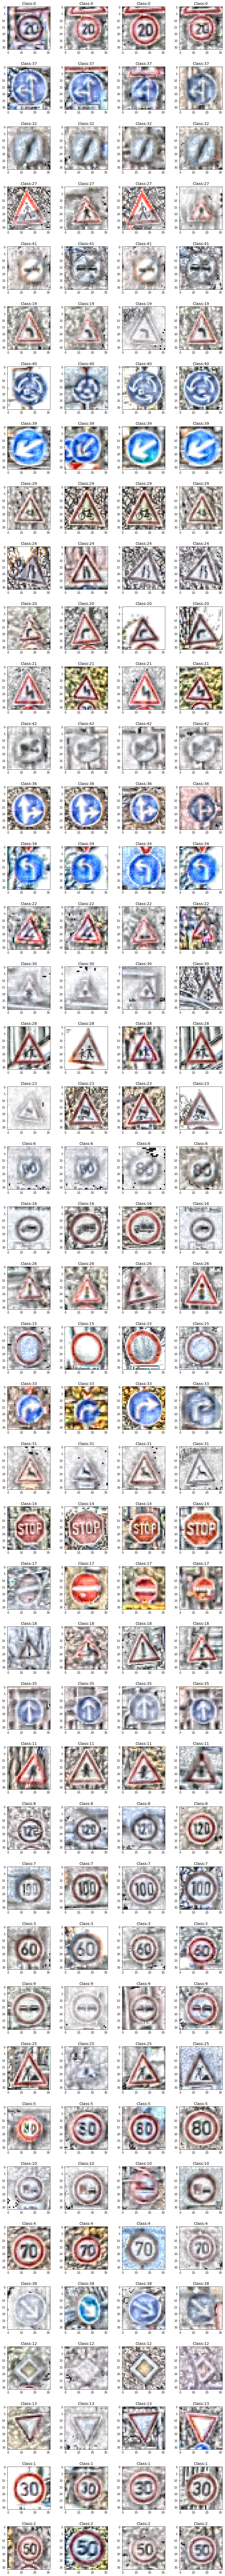

In [17]:
f, axarr = plt.subplots(n_classes, 4, figsize=(15,n_classes*4))
plt.figure()
f.subplots_adjust(hspace = .4, wspace=.001)
for i in range(0, len(indices)):    
    for j in range (4):
        randomIndex = np.random.randint(low=0, high=freq[i])
        subtitle = "Class:" + str(y_test[indices[i] + randomIndex])
        axarr[i,j].set_title(subtitle, fontsize=14)
        axarr[i,j].set_aspect(aspect=1, adjustable='box')
        axarr[i,j].imshow(np.round(X_test[indices[i] + randomIndex]).astype(np.uint8))


ALL preprocessed DATA has been saved!


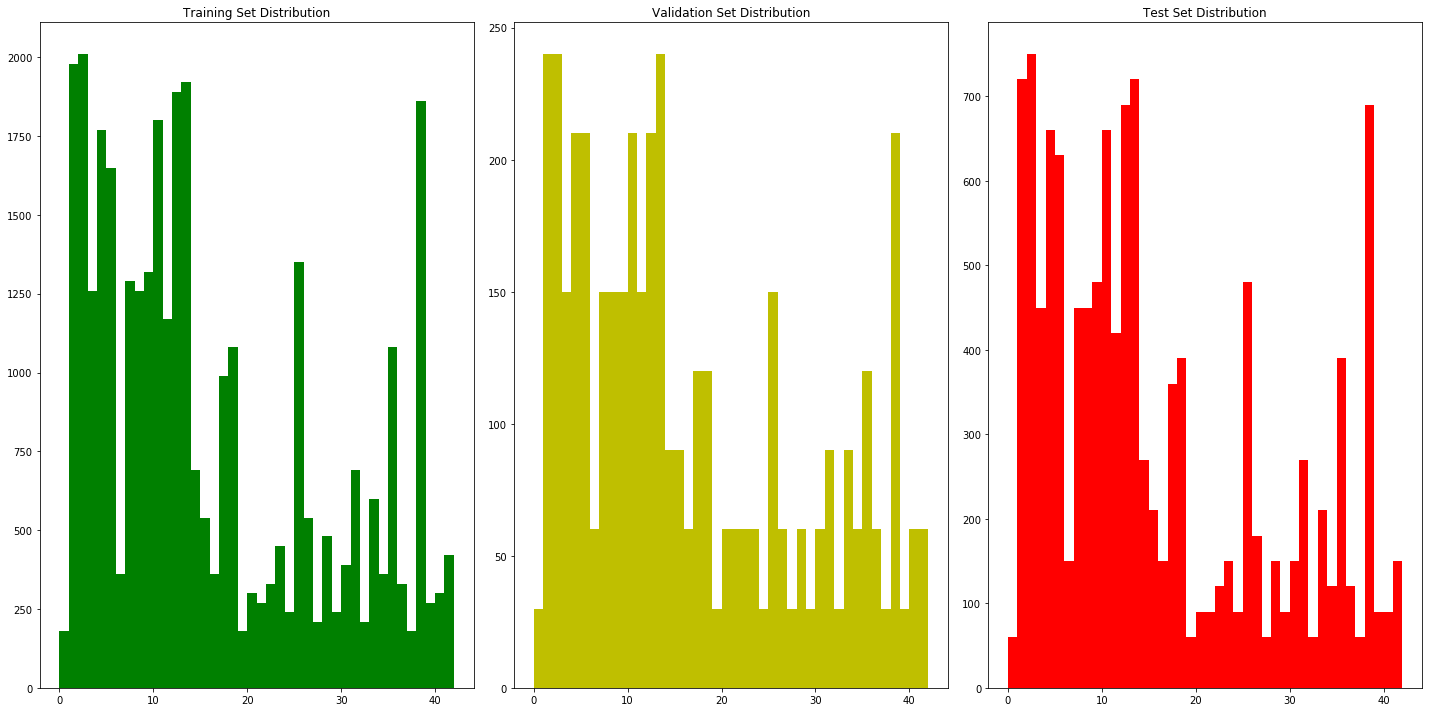

NameError: name 'stacked' is not defined

In [18]:
#backup['X_train'] = X_train 
#backup['X_valid'] = X_valid
#backup['X_test'] = X_test

print("ALL preprocessed DATA has been saved!")
#visualizing preprocessed contrast normalized data set

bins = range(n_classes)       
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 10))

ax0.hist(y_train, bins,  histtype='stepfilled', facecolor='g')
ax0.set_title('Training Set Distribution')

# Create a histogram by providing the bin edges (unequally spaced).
ax1.hist(y_valid, bins, histtype='stepfilled', facecolor='y')
ax1.set_title('Validation Set Distribution')


# Create a histogram by providing the bin edges (unequally spaced).
ax2.hist(y_test, bins,  histtype='stepfilled', facecolor='r')
ax2.set_title('Test Set Distribution')

fig.tight_layout()
plt.show()
plt.close('all')

combined = stacked[:,np.argsort(stacked[0])]

#leave the relative distributions of the signs the same -> biases the model to pick the sign with higher frequency 
#in the training set at times of uncertainty


# ----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [19]:
backup['y_train'] = y_train 
        

TypeError: cannot properly create the storer for: [_TYPE_MAP] [group->/y_train (Group) '',value-><class 'numpy.ndarray'>,format->fixed,append->False,kwargs->{'encoding': None}]

In [20]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
 
X_train, y_train = shuffle(X_train, y_train)

X_train = ( X_train - np.mean(X_train) ) / np.std(X_train)
X_valid = ( X_valid - np.mean(X_valid) ) / np.std(X_valid)
X_test = ( X_test - np.mean(X_test) ) / np.std(X_test)

### Model Architecture

In [21]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 128


from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6*2), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6*2))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    tf.nn.dropout(conv1, keep_prob=0.5)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6*2, 16*2), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16*2))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    tf.nn.dropout(conv2, keep_prob=0.5)
    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400*2, 120*2), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120*2))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120*2, 84*2), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84*2))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    tf.nn.dropout(fc2, keep_prob=0.5)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84*2, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    regularizers = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W)
    
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, tf.cast(n_classes, tf.int32))


### Train, Validate and Test the Model

# A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
### Train your model here.
rate = 0.001

#batch_x_test, batch_y_test = create_train_batch(X_train[0:2], y_train[0:2], 2)
#f, axarr = plt.subplots(20,1 , figsize=(32,32))
#plt.figure()
#f.subplots_adjust(hspace=.5)
#y_index = 0
#for i in range(20):    
#    subtitle = "Class:" + str(batch_y_test[i]) 
#    axarr[i].set_title(subtitle, fontsize=25)
#    axarr[i].imshow(batch_x_test[i].squeeze())
#    axarr[i].set_aspect(aspect=1, adjustable='box') 

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * BATCH_SIZE)
    return total_accuracy / (num_examples)

### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #if end < num_examples:
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:end],BATCH_SIZE, extra_data_per_element=4)
            #else: 
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:offset+BATCH_SIZE], num_examples - offset, extra_data_per_element=4)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")



### Feel free to use as many code cells as needed.

Training...

EPOCH 1 ...
Validation Accuracy = 0.926

EPOCH 2 ...
Validation Accuracy = 0.944

EPOCH 3 ...
Validation Accuracy = 0.954

EPOCH 4 ...
Validation Accuracy = 0.950

EPOCH 5 ...
Validation Accuracy = 0.954

EPOCH 6 ...
Validation Accuracy = 0.955

EPOCH 7 ...
Validation Accuracy = 0.964

EPOCH 8 ...
Validation Accuracy = 0.962

EPOCH 9 ...
Validation Accuracy = 0.956

EPOCH 10 ...
Validation Accuracy = 0.962

EPOCH 11 ...
Validation Accuracy = 0.965

EPOCH 12 ...
Validation Accuracy = 0.969

EPOCH 13 ...
Validation Accuracy = 0.963

EPOCH 14 ...
Validation Accuracy = 0.978

EPOCH 15 ...
Validation Accuracy = 0.984

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.966

EPOCH 18 ...
Validation Accuracy = 0.960

EPOCH 19 ...
Validation Accuracy = 0.973

EPOCH 20 ...
Validation Accuracy = 0.980

EPOCH 21 ...
Validation Accuracy = 0.988

EPOCH 22 ...
Validation Accuracy = 0.976

EPOCH 23 ...
Validation Accuracy = 0.982

EPOCH 24 ...
Validation Accura

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


# Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")